In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.stats import norm

# Using the lognormal from numba_stats
# unstead of scipy_stats speeds things
# up by a big factor.
# Be careful however because the call sequences
# are not exactly the sameand not all
# functions are implemented.
# from scipy.stats import lognorm
from numba_stats import lognorm

### This is fake data with 3 point

In [2]:
# This is some fake data in 3 bins
data = np.array([ 7,  6, 1])  # observed
sig  = np.array([ 2,  2, 2])  # signal predicted with mu=1
bg   = np.array([10,  5, 2])  # bg predicted
err  = 0.2*bg                 # bg uncertainty

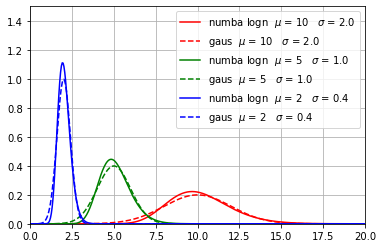

In [3]:
# check that lognormal makese sense, compare with gaussian
color = ('red', 'green', 'blue')
ax=plt.subplot(111)
for b,e,c in zip(bg, err, color):
    x = np.linspace(0.01, 20., 400)
    ax.plot(x, lognorm.pdf(x, np.log(1+e/b), 0, b), color=c, 
            label='numba logn  $\mu$ = '+str(b) + '   $\sigma$ = ' + str(e))
    ax.plot(x, norm.pdf(x,    scale=e, loc=b), color=c, linestyle='dashed', 
            label='gaus  $\mu$ = '+str(b) + '   $\sigma$ = ' + str(e))

ax.grid()
ax.legend()
ax.set_xlim([0, 20.])
_ = ax.set_ylim(0,1.5)

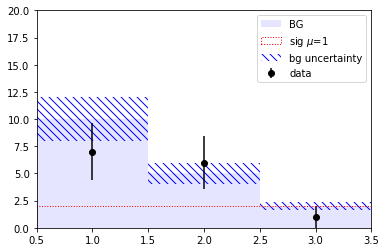

In [4]:
# plot it
x = np.array([1.,2.,3.])
b = np.array([0.5, 1.5, 2.5, 3.5, 4.5])
ax = plt.subplot(111)
ax.hist(x, b, weights=bg,  alpha=0.1, color='blue', label='BG', histtype='stepfilled')

n1,b1,p1 = ax.hist(x, b, weights=bg+err, histtype='stepfilled',
                   facecolor='none', edgecolor='none', linestyle='--')
n2,b2,p2 = ax.hist(x, b, weights=bg-err, histtype='stepfilled', 
                   facecolor='none', edgecolor='none', linestyle='--')
ax.bar(x=b1[:-1], height=n2-n1, bottom=n1, width=np.diff(b1),
       align='edge', linewidth=0, edgecolor='blue', color='none', zorder=-1, 
       label='bg uncertainty', hatch='\\\\\\')

ax.hist(x, b, weights=sig, color='red', label='sig $\mu$=1', histtype='step',
        linestyle='dotted')
ax.errorbar(x, data, yerr=np.sqrt(data), fmt='o', color='black', label='data')
# ax.bar(x, sig, align='center',width=1, color='None', edgecolor='red', label='sig ($\mu$=1)')

ax.set_xlim((0.5, 3.5))
ax.legend()
_ = ax.set_ylim((0,20))

In [5]:
class myFit:
    """
    Simplest example of wrapper around a minuit function
    NLL fit to bins of data = mu*signal + background
    including sigma of background (absolute)
    
    Sample usage:
    Example of 3 bins, np.arrays are to be passed.
    The fit parameters ordered for pinit are
       mu, 1st bin bg, 2bd bin bg, 3rd bin bg
    
    f = myFit(data, signal, background, sigma)
    m = Minuit(f.myNLL, pinit, name=("mu", "b1", "b2", 'b3'))
    m.errordef = Minuit.LIKELIHOOD
    m.simplex()
    m.migrad()
    m.minos()
    
    After defining "f" can change data members as
    f.d  = newData
    f.b  = newBG
    f.s  = newSignal
    f.eb = newBGsigma
    """
    def __init__(self, d, s, b, eb):
        self.d     = d
        self.b     = b
        self.eb    = eb
        self.s     = s
        self.blah  = np.log(1+eb/b)

    # This should really protect against logs of negative numbers
    def myNLL(self, p):
        mu = p[0]
        fitbg = p[1:]
        temp1 = (-self.d * np.log(mu*self.s + fitbg) + mu*self.s + fitbg).sum()
        #temp2 = 0
        #for bb,ee,fit in zip(self.b, self.eb, fitbg):
        #    pdf = lognorm.pdf(fit, np.log(1+ee/bb), scale=bb)
        #   temp2 = temp2 - np.log(pdf)
        #return temp1+temp2
        return temp1 - (np.log(lognorm.pdf(fitbg, self.blah, 0, self.b))).sum()

In [6]:
# Initialize a myFit object that contains the
# data, the signal model (mu=1), the pre-fit bg
# prediction, its uncertainty, as well as the
# negative log-likelihood function
thisFit = myFit(data, sig, bg, err)

# initialize a Minuit object with pinit as the initial guess
pinit     = np.array([1, bg[0], bg[1], bg[2]])
mData = Minuit(thisFit.myNLL, pinit, name=("mu", "b1", "b2", 'b3'))
mData.errordef = Minuit.LIKELIHOOD
mData.limits['mu'] = (0, None)   # force mu>=0 
#mData.simplex()
#mData.migrad()
#mData.minos()

In [7]:
mData.simplex()
mData.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.475                     │              Nfcn = 155              │
│ EDM = 4.2e-05 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │    0.0    │    0.4    │            │            │    0    │         │       │
│ 1 │ b1   │    9.0    │    1.4    │            │            │         │         │       │
│ 2 │ b2   │    5.0    │    0.8    │            │            │         │         │       │
│ 3 │ b3   │   1.88    │   0.33    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────┐
│    │        mu        b1        b2        b3 │
├────┼─────────────────────────────────────────┤
│ mu │  1.67e-05  -4.5e-06 -4.31e-06 -7.88e-07 │
│ b1 │  -4.5e-06      2.09  1.16e-06  2.13e-07 │
│ b2 │ -4.31e-06  1.16e-06     0.713  2.04e-07 │
│ b3 │ -7.88e-07  2.13e-07  2.04e-07     0.111 │
└────┴─────────────────────────────────────────┘

In [8]:
mData.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.475                     │              Nfcn = 594              │
│ EDM = 4.2e-05 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   8e-6    │ 417915e-6 │   -8e-6    │ 372808e-6  │    0    │         │       │
│ 1 │ b1   │    9.0    │    1.4    │    -1.4    │    1.6     │         │         │       │
│ 2 │ b2   │    5.0    │    0.8    │    -0.8    │    0.9     │         │         │       │
│ 3 │ b3   │   1.88    │   0.33    │   -0.31    │    0.36    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          mu           │          b1           │          b2           │          b3           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -8e-6   │ 372808e-6 │   -1.4    │    1.6    │   -0.8    │    0.9    │   -0.31   │   0.36    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   True    │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬─────────────────────────────────────────┐
│    │        mu        b1        b2        b3 │
├────┼─────────────────────────────────────────┤
│ mu │  1.67e-05  -4.5e-06 -4.31e-06 -7.88e-07 │
│ b1 │  -4.5e-06      2.09  1.16e-06  2.13e-07 │
│ b2 │ -4.31e-06  1.16e-06     0.713  2.04e-07 │
│ b3 │ -7.88e-07  2.13e-07  2.04e-07     0.111 │
└────┴─────────────────────────────────────────┘

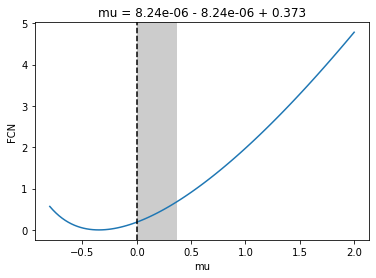

In [9]:
# Show a profile log likelihood scan (this is just for fun)
mu, loglik= mData.draw_mnprofile("mu",size=100, bound=[-0.8,2], subtract_min=True)

Text(0, 0.5, '$\\Delta$log-lik')

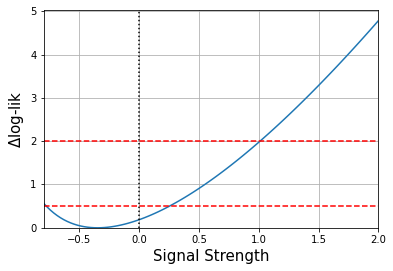

In [10]:
# It does not look so pretty, but we can redraw it
ax = plt.subplot(111)
ax.plot(mu,loglik)
ax.set_xlim(mu[0], mu[-1])
ax.set_ylim(bottom=0)
ax.grid()
ax.plot([0,0],[0,ax.get_ylim()[1]], color='black',linestyle='dotted')
ax.plot([mu[0], mu[-1]], [0.5, 0.5], color='red', linestyle='dashed')
ax.plot([mu[0], mu[-1]], [2.0, 2.0], color='red', linestyle='dashed')
ax.set_xlabel("Signal Strength", size=15)
ax.set_ylabel("$\Delta$log-lik", size=15)

In [11]:
 def getTestStat(theFit, theMu, theFitVal):
    """"
    Calculate the LHC-style test statistic
    Input:
        theFit    = a myFit object that has already been fit
        theMu     = the value of mu at which we calculate the test statistics
        theFitVal = the "best" value of mu
    Outputs:
        test_statistics, fitted_values_at_mu=theMu
    """
    pinit = np.array([theMu, bg[0], bg[1], bg[2]])  # initial guesses
    m1 = Minuit(theFit.myNLL, pinit, name=("mu", "b1", "b2", "b3"))
    m1.fixed['mu'] = True
    m1.errordef = Minuit.LIKELIHOOD
    m1.simplex()
    m1.migrad()
    
    mu0 = max(theFitVal, 0)
    pinit = np.array([mu0, bg[0], bg[1], bg[2]])  # initial guesses
    m0 = Minuit(theFit.myNLL, pinit, name=("mu", "b1", "b2", "b3"))
    m0.fixed['mu'] = True
    m0.errordef = Minuit.LIKELIHOOD
    m0.simplex()
    m0.migrad()
    
    return 2*(m1.fval-m0.fval), m1.values

In [12]:
# This is not being used
def plotCL(ax, clb, clsb, qmu):
    """
    plot CLS as a function of qmu of axis ax give CL_b and CL_s+b
    """
    # make sure that qmu is on a bin boundary...put it in the middle
    nbin = 30
    minx = np.amin(clsb)-2
    maxx = np.amax(clb)+2
    step = (maxx-minx)/nbin
    # print((qmu-minx)/step)
    minx = qmu-int((qmu-minx)/step)*step
    bins = np.linspace(minx, minx+nbin*step, nbin+1)
    _ = ax.hist(clb, bins, histtype='step', color='blue',   label="B-only")
    _ = ax.hist(clsb,bins, histtype='step', color='orange', label="S+B")
    _ = ax.hist(clb[clb<qmu],    bins, histtype='stepfilled', color='blue', alpha=0.2, label="1-CL$_B$")
    _ = ax.hist(clsb[clsb>qmu],  bins, histtype='stepfilled', color='orange', alpha=0.2, label="CL$_{S+B}$")
    ax.set_xlim([bins[0], bins[-1]])
    ax.legend()

In [13]:
# %%timeit -n1 -r1
# Scan mu, construct CLS and calculate its error
np.random.seed(12345)
Ntoys = 5000
muToScan = np.array([0.9,1.0,1.1,1.15,1.2,1.25,1.3,1.4,1.45])
CLS=[]
CLS_Error=[]

for mu in muToScan:
    print("Running ", Ntoys, " toys for mu = ",mu)
    
    # Get data (ie: observed) test stat at this mu
    # and also the value of the BG fit at this mu
    qmuobs, outVal = getTestStat(thisFit, mu, mData.values[0])
    
    # generate BG toys
    tempB  = []
    thisBG = np.array([outVal[1], outVal[2], outVal[3]])
    for b in thisBG:
            tempB.append(np.random.poisson(b,Ntoys))
    bgToys = np.array(tempB)
    
    # generate signal toys
    tempS  = []
    for s in sig:
        tempS.append(np.random.poisson(mu*s, Ntoys))
    sigToys = np.array(tempS)
    
    # Now fit toys
    CLB  = []
    CLSB = []
    for i in range(Ntoys):
        # if i % 100 == 0: print(i, mu)
            
        # Fit B toys     
        thisData = bgToys[:,i]
        bgFit = myFit(thisData, sig, bg, err)
        pinit = np.array([1, bg[0], bg[1], bg[2]])  # initial guesses
        mB= Minuit(bgFit.myNLL, pinit, name=("mu", "b1", "b2", "b3"))
        mB.limits['mu'] = (0, None)
        mB.errordef = Minuit.LIKELIHOOD
        mB.simplex()
        mB.migrad()   
        if mB.values[0] > mu:
            CLB.append(0)
        else:
            q, out = getTestStat(bgFit, mu, mB.values[0])   
            CLB.append(q)
        
        
        thisData = bgToys[:,i] + sigToys[:,i]
        splusbFit = myFit(thisData, sig, bg, err)
        pinit = np.array([1, bg[0], bg[1], bg[2]])  # initial guesses
        mSB= Minuit(splusbFit.myNLL, pinit, name=("mu", "b1", "b2", "b3"))
        mSB.limits['mu'] = (0, None)
        mSB.errordef = Minuit.LIKELIHOOD
        mSB.simplex()
        mSB.migrad()  
        if mSB.values[0] > mu:
            CLSB.append(0)
        else:
            q, out = getTestStat(splusbFit, mu, mSB.values[0])   
            CLSB.append(q)
    
    # Calculates CLs 
    # (rely on the fact that the number of S and S+B toys are the same)
    cl_b  = np.array(CLB)
    cl_sb = np.array(CLSB)
    num = (cl_sb>qmuobs).sum()
    den = (cl_b>qmuobs).sum()
    CLs = num/den
    # print(num,den, num/den)
    errCLs = CLs * np.sqrt(1/num + 1/den)
    # print(CLs, errCLs)
    CLS.append(CLs)
    CLS_Error.append(errCLs)
    
 

Running  5000  toys for mu =  0.9
Running  5000  toys for mu =  1.0
Running  5000  toys for mu =  1.1
Running  5000  toys for mu =  1.15
Running  5000  toys for mu =  1.2
Running  5000  toys for mu =  1.25
Running  5000  toys for mu =  1.3
Running  5000  toys for mu =  1.4
Running  5000  toys for mu =  1.45


Text(0, 0.5, '$CL_S$')

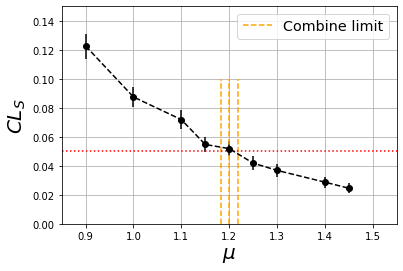

In [16]:
ax = plt.subplot(111)
ax.plot((1.20,1.20), (0,0.1), label='Combine limit', linestyle='dashed', color='orange')
ax.plot((1.20+0.018,1.20+0.018), (0,0.1), linestyle='dashed', color='orange')
ax.plot((1.20-0.018,1.20-0.018), (0,0.1), linestyle='dashed', color='orange')

ax.errorbar(muToScan, np.array(CLS), yerr=np.array(CLS_Error), linestyle='dashed',
           color='black', fmt='o')
ax.grid()
ax.legend(fontsize='x-large')
ax.set_ylim(0, 0.15)
ax.set_xlim([0.85,1.55])
ax.plot((0.85, 1.55), (0.05,0.05), color='red', linestyle='dotted')
ax.set_xlabel('$\mu$', size=20)
ax.set_ylabel('$CL_S$', size=20)

<hr style="border:2px solid blue"> </hr>
Do the exact same wth the CMS combine softare. <br>
Here is the txt file

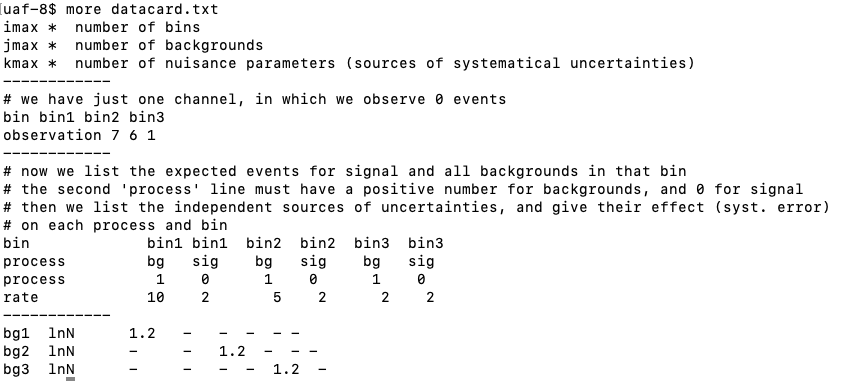

Here are the commads used

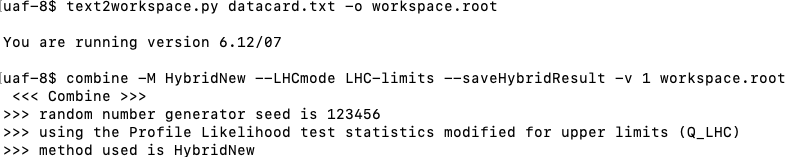

And here is the result

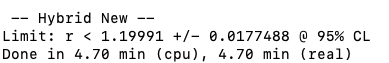